In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv('weather.csv')


In [3]:
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [4]:
data['Time'] = pd.date_range(start='2012-01-01', periods=len(data), freq='M')


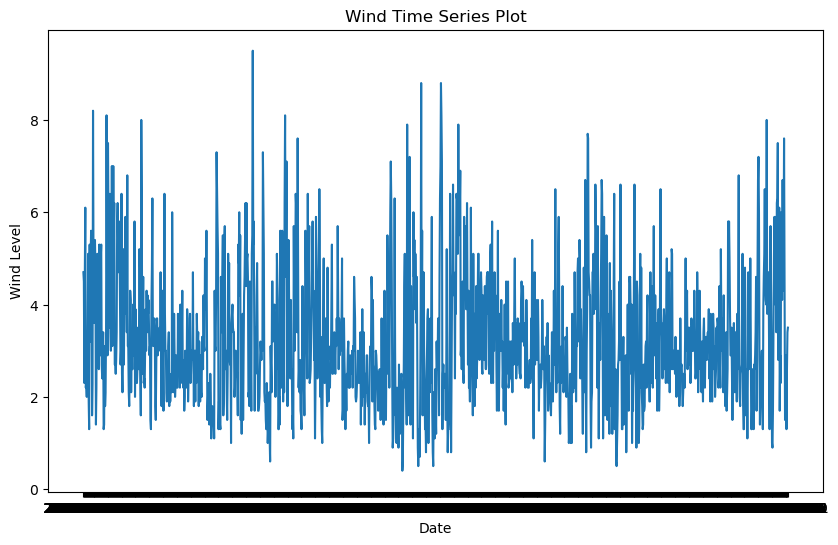

In [5]:
data.set_index('date', inplace=True)
time_series = data['wind']
plt.figure(figsize=(10, 6))
plt.plot(time_series)
plt.title('Wind Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Wind Level')
plt.show()

In [6]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    if result[1] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

In [7]:
test_stationarity(time_series)
time_series_diff = time_series.diff().dropna()
print("\nAfter Differencing:")
test_stationarity(time_series_diff)
# Set initial SARIMA parameters (p, d, q, P, D, Q, m)
p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, 12  # m = 12 for monthly seasonality if applicable
model = SARIMAX(time_series, order=(p, d, q), seasonal_order=(P, D, Q, m), enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = model.fit(disp=False)
print(sarima_fit.summary())
forecast_steps = 12  # Number of periods to forecast
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

ADF Statistic: -24.507371901200777
p-value: 0.0
Critical Value 1%: -3.434836872962171
Critical Value 5%: -2.863521656701378
Critical Value 10%: -2.567825016419591
The time series is stationary.

After Differencing:
ADF Statistic: -12.491872535066454
p-value: 2.933289221133926e-23
Critical Value 1%: -3.4349151819757466
Critical Value 5%: -2.863556216004778
Critical Value 10%: -2.5678434198545568
The time series is stationary.
                                     SARIMAX Results                                      
Dep. Variable:                               wind   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2434.598
Date:                            Mon, 05 May 2025   AIC                           4879.196
Time:                                    09:12:48   BIC                           4905.537
Sample:                                01-01-2012   HQIC                          4889.031
                         

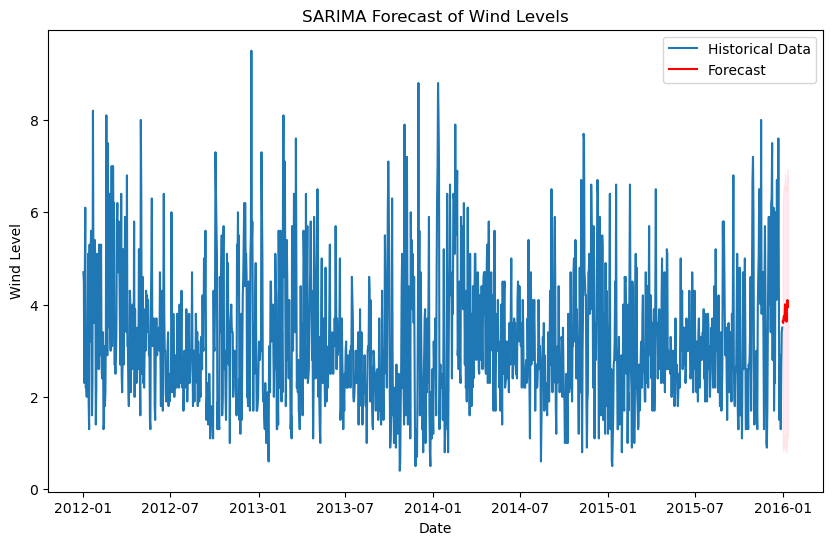

In [8]:
# Ensure time series index is datetime and timezone-naive
time_series.index = pd.to_datetime(time_series.index).tz_localize(None)
forecast.predicted_mean.index = pd.to_datetime(forecast.predicted_mean.index).tz_localize(None)
forecast_ci.index = pd.to_datetime(forecast_ci.index).tz_localize(None)


plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Historical Data')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast of Wind Levels')
plt.xlabel('Date')
plt.ylabel('Wind Level')
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import mean_absolute_error
test_data = time_series[-forecast_steps:]
pred_data = forecast.predicted_mean[:len(test_data)]
mae = mean_absolute_error(test_data, pred_data)
print('Mean Absolute Error:', mae)


Mean Absolute Error: 1.5740073946010391
